In [56]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from bayes_opt import BayesianOptimization
import time
import warnings
warnings.filterwarnings('ignore')

In [57]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Standardizing the numerical columns so that all the values in these columns are on the same numerical scale
    #Filling the nan values in these categorical features with the mode value
    #Transforming the categorical features to store int labels
    label_encoder = preprocessing.LabelEncoder()
    for col in cols:
        if col in numericalCols:
            if col == "Age":
                data[col] = data[col].fillna(data[col].mean())
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = (data[col] - data[col].mean())/(data[col].std())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = label_encoder.fit_transform(data[col])
            data[col] = data[col].astype(int)
        
    return data
    

In [58]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)
X = data.drop(columns=["Transported"])
y = data["Transported"]

#Using Bayesian Optimization to tune the hyperparameters
max_score = (0, {})
def generateDecisionTree(splitter, max_depth, min_samples_split, min_samples_leaf, max_features):
    splitters = ["best", "random"]
    if max_depth == 11:
        return DecisionTreeClassifier(splitter = splitters[splitter], max_depth = None, 
                                  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, 
                                  random_state = 1, max_features = max_features)
    else:
        return DecisionTreeClassifier(splitter = splitters[splitter], max_depth = max_depth, 
                                  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, 
                                  random_state = 1, max_features = max_features)
        

def score(splitter, max_depth, min_samples_split, min_samples_leaf, max_features):
    splitter = round(splitter)
    max_depth = round(max_depth)
    min_samples_split = round(min_samples_split)
    min_samples_leaf = round(min_samples_leaf)
    max_features = round(max_features)
    
    def generateModel():
        return generateDecisionTree(splitter, max_depth, min_samples_split, min_samples_leaf, max_features)
        
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = generateModel()
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=kfold)
    mean_acc = scores.mean()
    global max_score
    if mean_acc > max_score[0]:
        max_score = (mean_acc, {
            'splitter': splitter,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features
        })
    return mean_acc

hyperparams = {
    'splitter': (0, 1),
    'max_depth': (1, 11),
    'min_samples_split': (10, 40),
    'min_samples_leaf': (10,20),
    'max_features': (1, 12)
}
start = time.time()
bo = BayesianOptimization(score, hyperparams, random_state=1)
bo.maximize(init_points=1000, n_iter=50)
print("Best Accuracy: %f using %s" % (max_score[0], str(max_score[1])))
end = time.time()
elapsedTime = end - start
print("Elapsed Time: " + str(elapsedTime) + " seconds")

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | splitter  |
-------------------------------------------------------------------------------------
| 1         | 0.771     | 5.17      | 8.924     | 10.0      | 19.07     | 0.1468    |
| 2         | 0.598     | 1.923     | 3.049     | 13.46     | 21.9      | 0.5388    |
| 3         | 0.7723    | 5.192     | 8.537     | 12.04     | 36.34     | 0.02739   |
| 4         | 0.782     | 7.705     | 5.59      | 15.59     | 14.21     | 0.1981    |
| 5         | 0.7612    | 9.007     | 11.65     | 13.13     | 30.77     | 0.8764    |
| 6         | 0.688     | 9.946     | 1.935     | 10.39     | 15.09     | 0.8781    |
| 7         | 0.7184    | 1.983     | 5.632     | 19.58     | 25.99     | 0.6919    |
| 8         | 0.7184    | 4.155     | 8.552     | 18.35     | 10.55     | 0.7501    |
| 9         | 0.7789    | 10.89     | 9.23      | 12.8      | 33.68     | 0.1032    |
| 10        | 0.7726    | 5.479     | 10.99     | 12.9

| 58        | 0.7519    | 9.549     | 6.805     | 18.02     | 27.17     | 0.7331    |
| 59        | 0.7744    | 6.19      | 9.48      | 15.69     | 23.97     | 0.3427    |
| 60        | 0.7312    | 1.682     | 5.157     | 10.8      | 39.48     | 0.1816    |
| 61        | 0.7776    | 9.119     | 10.62     | 16.88     | 27.08     | 0.161     |
| 62        | 0.7729    | 5.669     | 4.797     | 12.25     | 27.78     | 0.3123    |
| 63        | 0.778     | 10.16     | 11.01     | 12.57     | 13.33     | 0.193     |
| 64        | 0.7518    | 5.996     | 9.014     | 12.08     | 17.44     | 0.8517    |
| 65        | 0.7345    | 5.158     | 7.784     | 12.34     | 13.06     | 0.5159    |
| 66        | 0.7247    | 5.771     | 2.679     | 16.22     | 26.32     | 0.6541    |
| 67        | 0.7177    | 2.445     | 9.267     | 12.22     | 25.58     | 0.7853    |
| 68        | 0.5973    | 1.223     | 4.568     | 18.73     | 35.34     | 0.5384    |
| 69        | 0.7797    | 9.666     | 11.45     | 18.2

| 116       | 0.7734    | 6.785     | 4.015     | 15.61     | 30.15     | 0.3524    |
| 117       | 0.7443    | 9.558     | 3.145     | 17.47     | 18.69     | 0.7738    |
| 118       | 0.7362    | 5.277     | 9.885     | 13.54     | 16.41     | 0.7673    |
| 119       | 0.7656    | 4.086     | 9.066     | 17.44     | 16.64     | 0.2141    |
| 120       | 0.7183    | 2.989     | 2.568     | 13.77     | 10.8      | 0.1109    |
| 121       | 0.7832    | 7.746     | 9.798     | 10.81     | 16.95     | 0.2076    |
| 122       | 0.7737    | 10.17     | 8.824     | 15.54     | 19.14     | 0.8349    |
| 123       | 0.7708    | 5.353     | 11.16     | 17.06     | 24.34     | 0.1262    |
| 124       | 0.7746    | 10.76     | 2.758     | 12.03     | 22.94     | 0.4042    |
| 125       | 0.7177    | 2.468     | 9.023     | 11.89     | 29.32     | 0.7543    |
| 126       | 0.732     | 3.107     | 7.61      | 17.49     | 29.15     | 0.5971    |
| 127       | 0.7184    | 3.955     | 9.048     | 19.4

| 175       | 0.598     | 1.53      | 3.194     | 14.23     | 13.23     | 0.6237    |
| 176       | 0.5973    | 1.48      | 4.131     | 10.61     | 31.11     | 0.6685    |
| 177       | 0.6639    | 4.786     | 3.07      | 17.47     | 20.21     | 0.7953    |
| 178       | 0.769     | 5.879     | 6.782     | 10.28     | 29.33     | 0.3507    |
| 179       | 0.7209    | 3.292     | 5.773     | 13.82     | 24.09     | 0.9795    |
| 180       | 0.7665    | 4.644     | 9.519     | 15.53     | 36.67     | 0.355     |
| 181       | 0.7183    | 3.455     | 11.02     | 10.44     | 38.52     | 0.5564    |
| 182       | 0.7722    | 4.764     | 11.95     | 10.58     | 25.5      | 0.0311    |
| 183       | 0.7244    | 6.712     | 2.985     | 16.31     | 39.43     | 0.8749    |
| 184       | 0.7477    | 5.518     | 8.793     | 17.77     | 24.85     | 0.5285    |
| 185       | 0.7335    | 2.508     | 5.063     | 11.42     | 31.81     | 0.477     |
| 186       | 0.7707    | 5.489     | 10.75     | 15.2

| 233       | 0.752     | 5.277     | 2.094     | 11.15     | 21.2      | 0.1938    |
| 234       | 0.785     | 9.207     | 7.596     | 16.89     | 24.73     | 0.08817   |
| 235       | 0.721     | 3.351     | 6.078     | 11.99     | 10.76     | 0.7294    |
| 236       | 0.7528    | 8.249     | 4.634     | 18.43     | 22.85     | 0.8647    |
| 237       | 0.7523    | 7.571     | 7.391     | 12.01     | 25.89     | 0.8944    |
| 238       | 0.7183    | 4.05      | 10.58     | 19.09     | 19.9      | 0.6831    |
| 239       | 0.7196    | 9.992     | 1.833     | 18.79     | 15.73     | 0.8498    |
| 240       | 0.7597    | 7.671     | 4.788     | 11.51     | 29.06     | 0.8478    |
| 241       | 0.782     | 9.218     | 7.911     | 19.56     | 27.7      | 0.1978    |
| 242       | 0.6824    | 5.293     | 4.704     | 19.92     | 21.41     | 0.9927    |
| 243       | 0.7608    | 6.188     | 2.895     | 10.75     | 21.11     | 0.1234    |
| 244       | 0.7788    | 7.345     | 5.553     | 19.9

| 292       | 0.7761    | 6.738     | 10.61     | 12.45     | 28.89     | 0.03443   |
| 293       | 0.7757    | 6.162     | 10.5      | 19.84     | 10.3      | 0.2528    |
| 294       | 0.7074    | 3.238     | 1.523     | 10.1      | 24.71     | 0.04548   |
| 295       | 0.7297    | 3.783     | 8.04      | 12.95     | 18.09     | 0.5905    |
| 296       | 0.7722    | 4.805     | 8.728     | 14.96     | 29.0      | 0.3534    |
| 297       | 0.5189    | 3.87      | 2.465     | 19.37     | 34.15     | 0.938     |
| 298       | 0.7144    | 2.854     | 11.26     | 19.36     | 18.51     | 0.2746    |
| 299       | 0.7244    | 6.514     | 3.038     | 14.42     | 15.56     | 0.9474    |
| 300       | 0.7557    | 5.938     | 11.6      | 16.45     | 24.53     | 0.9677    |
| 301       | 0.7183    | 2.432     | 7.956     | 16.62     | 23.02     | 0.05936   |
| 302       | 0.7777    | 5.927     | 6.116     | 18.07     | 17.7      | 0.3914    |
| 303       | 0.7184    | 3.402     | 8.551     | 19.9

| 350       | 0.7183    | 1.511     | 11.12     | 19.27     | 26.56     | 0.9639    |
| 351       | 0.7626    | 3.81      | 7.624     | 13.96     | 28.84     | 0.3006    |
| 352       | 0.7614    | 9.194     | 1.768     | 10.42     | 11.48     | 0.1505    |
| 353       | 0.7371    | 4.954     | 11.51     | 11.11     | 29.43     | 0.5276    |
| 354       | 0.6629    | 4.532     | 3.18      | 12.21     | 11.31     | 0.7132    |
| 355       | 0.7424    | 7.538     | 5.881     | 17.19     | 13.3      | 0.9387    |
| 356       | 0.7796    | 9.476     | 8.249     | 13.79     | 22.5      | 0.4822    |
| 357       | 0.7635    | 10.35     | 10.5      | 14.78     | 26.64     | 0.8754    |
| 358       | 0.7645    | 10.49     | 8.031     | 17.49     | 20.55     | 0.918     |
| 359       | 0.7506    | 9.368     | 7.073     | 18.68     | 35.5      | 0.8084    |
| 360       | 0.7183    | 2.307     | 6.896     | 19.01     | 33.12     | 0.4207    |
| 361       | 0.7627    | 10.78     | 3.759     | 13.3

| 408       | 0.732     | 3.321     | 7.908     | 13.04     | 10.89     | 0.9033    |
| 409       | 0.7712    | 5.204     | 5.687     | 17.41     | 38.45     | 0.07252   |
| 410       | 0.7267    | 2.727     | 4.546     | 12.48     | 24.86     | 0.8245    |
| 411       | 0.7592    | 9.54      | 7.554     | 12.4      | 15.59     | 0.7434    |
| 412       | 0.735     | 3.372     | 6.934     | 17.49     | 16.85     | 0.1745    |
| 413       | 0.6122    | 1.397     | 2.623     | 18.51     | 13.14     | 0.2236    |
| 414       | 0.6657    | 1.328     | 8.44      | 12.32     | 22.41     | 0.1393    |
| 415       | 0.7708    | 4.772     | 5.669     | 14.73     | 22.69     | 0.1028    |
| 416       | 0.7748    | 8.726     | 2.509     | 14.24     | 18.16     | 0.301     |
| 417       | 0.7802    | 7.724     | 6.696     | 11.9      | 24.07     | 0.3395    |
| 418       | 0.7328    | 8.045     | 3.487     | 18.45     | 25.79     | 0.5006    |
| 419       | 0.7218    | 3.537     | 3.048     | 14.7

| 466       | 0.7621    | 4.772     | 8.3       | 10.86     | 26.5      | 0.01542   |
| 467       | 0.7653    | 10.83     | 7.583     | 13.84     | 14.4      | 0.6969    |
| 468       | 0.7454    | 10.06     | 4.499     | 17.66     | 18.62     | 0.9572    |
| 469       | 0.7499    | 8.023     | 7.875     | 19.31     | 18.07     | 0.9236    |
| 470       | 0.7614    | 7.781     | 9.485     | 15.72     | 35.02     | 0.6983    |
| 471       | 0.7183    | 2.466     | 7.737     | 12.79     | 37.48     | 0.1982    |
| 472       | 0.5189    | 3.857     | 1.524     | 14.48     | 26.73     | 0.5736    |
| 473       | 0.7576    | 10.05     | 4.822     | 14.48     | 35.54     | 0.5768    |
| 474       | 0.7774    | 7.54      | 4.062     | 14.87     | 28.63     | 0.1334    |
| 475       | 0.502     | 1.329     | 2.248     | 14.77     | 10.72     | 0.6262    |
| 476       | 0.7312    | 1.976     | 3.761     | 14.26     | 13.47     | 0.2706    |
| 477       | 0.7183    | 1.211     | 11.84     | 16.1

| 524       | 0.7347    | 5.136     | 7.536     | 11.25     | 33.56     | 0.62      |
| 525       | 0.7592    | 7.152     | 8.713     | 19.87     | 26.87     | 0.8644    |
| 526       | 0.7628    | 5.187     | 8.199     | 19.25     | 29.92     | 0.3031    |
| 527       | 0.7711    | 7.199     | 4.865     | 13.22     | 28.31     | 0.1603    |
| 528       | 0.7733    | 5.867     | 11.4      | 13.84     | 15.67     | 0.4688    |
| 529       | 0.782     | 9.409     | 10.27     | 18.28     | 10.34     | 0.267     |
| 530       | 0.759     | 11.0      | 2.317     | 14.9      | 33.7      | 0.1222    |
| 531       | 0.7817    | 7.624     | 6.369     | 11.94     | 36.36     | 0.1815    |
| 532       | 0.774     | 7.391     | 9.149     | 15.63     | 28.87     | 0.119     |
| 533       | 0.7244    | 4.08      | 7.457     | 13.95     | 29.92     | 0.852     |
| 534       | 0.7183    | 2.902     | 10.94     | 13.83     | 38.29     | 0.6174    |
| 535       | 0.7814    | 8.901     | 6.663     | 15.3

| 582       | 0.7806    | 7.601     | 8.642     | 13.13     | 11.13     | 0.4146    |
| 583       | 0.6122    | 3.26      | 1.012     | 16.86     | 38.56     | 0.3912    |
| 584       | 0.7244    | 4.003     | 7.091     | 18.52     | 33.85     | 0.6848    |
| 585       | 0.7421    | 5.321     | 8.595     | 12.16     | 18.52     | 0.7778    |
| 586       | 0.7769    | 10.3      | 3.091     | 12.96     | 10.19     | 0.4316    |
| 587       | 0.7316    | 3.103     | 8.056     | 17.1      | 13.56     | 0.08214   |
| 588       | 0.7633    | 10.06     | 5.282     | 15.33     | 38.9      | 0.7591    |
| 589       | 0.7339    | 4.255     | 1.944     | 15.36     | 20.08     | 0.02169   |
| 590       | 0.7595    | 8.712     | 5.234     | 15.71     | 32.67     | 0.9408    |
| 591       | 0.7743    | 7.123     | 4.469     | 11.1      | 12.22     | 0.3197    |
| 592       | 0.7802    | 7.608     | 8.647     | 12.08     | 12.48     | 0.3055    |
| 593       | 0.7506    | 6.476     | 9.301     | 15.3

| 640       | 0.7567    | 8.863     | 4.874     | 19.11     | 24.86     | 0.8727    |
| 641       | 0.7335    | 3.205     | 5.039     | 13.67     | 12.91     | 0.331     |
| 642       | 0.7835    | 7.597     | 6.132     | 18.79     | 18.09     | 0.3548    |
| 643       | 0.7244    | 4.204     | 7.069     | 11.88     | 15.2      | 0.9395    |
| 644       | 0.7616    | 4.766     | 7.458     | 10.55     | 14.23     | 0.09636   |
| 645       | 0.7581    | 9.121     | 2.135     | 15.16     | 14.67     | 0.2788    |
| 646       | 0.7852    | 9.826     | 7.948     | 19.64     | 27.99     | 0.00952   |
| 647       | 0.6263    | 5.156     | 1.247     | 13.14     | 24.45     | 0.5755    |
| 648       | 0.735     | 3.387     | 7.141     | 13.95     | 25.2      | 0.196     |
| 649       | 0.7184    | 2.568     | 9.3       | 13.3      | 29.33     | 0.5655    |
| 650       | 0.765     | 9.995     | 10.69     | 14.43     | 16.14     | 0.6322    |
| 651       | 0.7576    | 7.368     | 8.617     | 19.0

| 698       | 0.7738    | 8.847     | 5.403     | 13.08     | 33.62     | 0.4185    |
| 699       | 0.7679    | 5.968     | 7.351     | 18.2      | 27.44     | 0.4061    |
| 700       | 0.7144    | 2.606     | 8.723     | 18.83     | 13.25     | 0.4662    |
| 701       | 0.7611    | 10.35     | 7.199     | 15.45     | 11.9      | 0.5353    |
| 702       | 0.7328    | 7.545     | 2.613     | 19.56     | 15.88     | 0.6739    |
| 703       | 0.7339    | 3.743     | 2.193     | 12.61     | 20.02     | 0.4647    |
| 704       | 0.7184    | 3.344     | 9.003     | 18.07     | 33.73     | 0.7157    |
| 705       | 0.7218    | 3.696     | 3.315     | 11.09     | 21.9      | 0.08727   |
| 706       | 0.7797    | 7.554     | 11.45     | 17.56     | 13.51     | 0.02048   |
| 707       | 0.7223    | 4.349     | 11.92     | 13.13     | 32.13     | 0.7165    |
| 708       | 0.7721    | 6.726     | 5.044     | 12.08     | 39.4      | 0.06589   |
| 709       | 0.7523    | 3.362     | 4.398     | 19.1

| 757       | 0.7787    | 7.973     | 8.846     | 18.22     | 28.87     | 0.4222    |
| 758       | 0.6657    | 1.308     | 7.55      | 15.64     | 28.02     | 0.3229    |
| 759       | 0.725     | 6.549     | 2.888     | 16.5      | 12.15     | 0.8751    |
| 760       | 0.7184    | 3.161     | 4.232     | 18.85     | 36.51     | 0.8363    |
| 761       | 0.7183    | 4.269     | 10.93     | 17.72     | 29.74     | 0.8998    |
| 762       | 0.7804    | 8.831     | 5.672     | 13.24     | 21.82     | 0.06141   |
| 763       | 0.6887    | 4.634     | 4.883     | 18.66     | 36.66     | 0.9631    |
| 764       | 0.7185    | 4.282     | 8.627     | 16.33     | 17.27     | 0.87      |
| 765       | 0.7184    | 3.141     | 9.225     | 11.45     | 13.2      | 0.7203    |
| 766       | 0.7277    | 6.263     | 5.872     | 17.78     | 20.76     | 0.8533    |
| 767       | 0.7818    | 10.62     | 11.77     | 12.78     | 22.45     | 0.725     |
| 768       | 0.779     | 9.949     | 8.824     | 17.5

| 816       | 0.7327    | 5.115     | 6.244     | 17.21     | 13.67     | 0.5031    |
| 817       | 0.7573    | 9.131     | 8.451     | 13.22     | 31.32     | 0.9344    |
| 818       | 0.775     | 9.948     | 9.165     | 12.66     | 21.17     | 0.5584    |
| 819       | 0.7327    | 4.81      | 6.013     | 17.94     | 13.12     | 0.973     |
| 820       | 0.7619    | 8.046     | 10.51     | 17.82     | 22.97     | 0.9425    |
| 821       | 0.5189    | 3.531     | 1.509     | 10.97     | 16.02     | 0.5391    |
| 822       | 0.7284    | 3.236     | 10.19     | 10.09     | 32.38     | 0.969     |
| 823       | 0.7625    | 3.672     | 7.862     | 17.15     | 19.81     | 0.4331    |
| 824       | 0.7515    | 8.344     | 2.443     | 11.44     | 21.26     | 0.2284    |
| 825       | 0.7218    | 4.07      | 2.651     | 10.97     | 37.48     | 0.3459    |
| 826       | 0.7748    | 6.66      | 7.019     | 14.5      | 32.43     | 0.3316    |
| 827       | 0.7618    | 9.925     | 1.748     | 15.7

| 874       | 0.7183    | 1.565     | 9.717     | 10.74     | 33.59     | 0.02795   |
| 875       | 0.6879    | 3.552     | 4.273     | 15.65     | 26.86     | 0.8874    |
| 876       | 0.7246    | 7.374     | 2.776     | 10.27     | 32.86     | 0.5356    |
| 877       | 0.7786    | 6.786     | 5.555     | 15.9      | 22.17     | 0.4457    |
| 878       | 0.7436    | 6.927     | 6.416     | 10.59     | 39.3      | 0.8551    |
| 879       | 0.7278    | 4.791     | 7.012     | 19.33     | 21.94     | 0.9448    |
| 880       | 0.7183    | 1.305     | 9.204     | 17.97     | 15.82     | 0.1629    |
| 881       | 0.7786    | 6.911     | 6.277     | 15.87     | 13.97     | 0.2777    |
| 882       | 0.5195    | 1.697     | 2.188     | 17.16     | 10.79     | 0.5397    |
| 883       | 0.7183    | 3.987     | 10.55     | 15.45     | 39.93     | 0.5611    |
| 884       | 0.7695    | 6.621     | 4.686     | 12.52     | 22.82     | 0.2272    |
| 885       | 0.7312    | 1.709     | 5.676     | 11.0

| 932       | 0.7654    | 4.457     | 9.353     | 14.27     | 22.7      | 0.2994    |
| 933       | 0.76      | 8.411     | 11.09     | 14.43     | 39.61     | 0.7995    |
| 934       | 0.7641    | 4.112     | 3.564     | 13.59     | 22.14     | 0.4959    |
| 935       | 0.7804    | 8.015     | 10.25     | 10.59     | 23.59     | 0.4276    |
| 936       | 0.7278    | 5.24      | 7.2       | 19.4      | 19.91     | 0.949     |
| 937       | 0.724     | 3.459     | 7.032     | 17.13     | 36.42     | 0.7817    |
| 938       | 0.7817    | 10.66     | 7.063     | 19.05     | 29.64     | 0.169     |
| 939       | 0.7183    | 1.307     | 9.369     | 16.78     | 18.65     | 0.106     |
| 940       | 0.7801    | 7.895     | 9.244     | 15.58     | 29.96     | 0.4041    |
| 941       | 0.7504    | 9.661     | 6.856     | 18.95     | 32.19     | 0.5229    |
| 942       | 0.755     | 8.197     | 10.75     | 11.95     | 22.89     | 0.8594    |
| 943       | 0.502     | 1.305     | 2.464     | 14.0

| 991       | 0.7267    | 3.41      | 5.08      | 11.5      | 34.11     | 0.717     |
| 992       | 0.7499    | 8.005     | 8.467     | 18.92     | 36.49     | 0.6254    |
| 993       | 0.7258    | 3.888     | 5.434     | 10.29     | 37.49     | 0.6874    |
| 994       | 0.7416    | 10.08     | 4.323     | 19.45     | 35.92     | 0.886     |
| 995       | 0.5973    | 1.001     | 5.15      | 11.22     | 37.98     | 0.5137    |
| 996       | 0.7307    | 5.893     | 6.356     | 15.7      | 26.34     | 0.9171    |
| 997       | 0.7752    | 9.844     | 9.621     | 13.23     | 33.53     | 0.1452    |
| 998       | 0.7769    | 9.602     | 9.503     | 17.76     | 25.86     | 0.4502    |
| 999       | 0.7284    | 3.266     | 9.895     | 19.66     | 26.31     | 0.9022    |
| 1000      | 0.7507    | 3.824     | 6.695     | 13.28     | 39.75     | 0.2503    |
| 1001      | 0.7558    | 5.614     | 2.043     | 16.59     | 28.97     | 0.4968    |
| 1002      | 0.7526    | 4.586     | 3.391     | 16.2

| 1049      | 0.7806    | 8.749     | 10.04     | 13.99     | 37.01     | 0.0       |
| 1050      | 0.7783    | 10.46     | 10.77     | 17.07     | 21.02     | 0.0       |
Best Accuracy: 0.787757 using {'splitter': 0, 'max_depth': 9, 'min_samples_split': 36, 'min_samples_leaf': 14, 'max_features': 8}
Elapsed Time: 1448.0026450157166 seconds


In [60]:
"""
According to the output above, the hyperparameter values that displayed the best performance are
{'splitter': 0, 'max_depth': 9, 'min_samples_split': 36, 'min_samples_leaf': 14, 'max_features': 8}
"""

hyperparams = max_score[1]

"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
model = generateDecisionTree(hyperparams['splitter'], hyperparams['max_depth'], hyperparams['min_samples_split'], hyperparams['min_samples_leaf'], hyperparams['max_features'])
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.83      0.82      4315
        True       0.82      0.81      0.82      4378

    accuracy                           0.82      8693
   macro avg       0.82      0.82      0.82      8693
weighted avg       0.82      0.82      0.82      8693



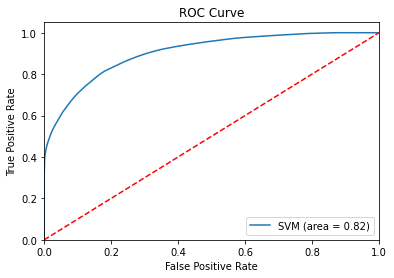

In [61]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [62]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)

model = generateDecisionTree(hyperparams['splitter'], hyperparams['max_depth'], hyperparams['min_samples_split'], hyperparams['min_samples_leaf'], hyperparams['max_features'])
model.fit(X, y)
y_pred = model.predict(test_data)

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission.to_csv('DecisionTreeSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.78396 on the test set